In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_events = pd.read_csv('data/athlete_events.csv', index_col='ID')
print(f'Il y à maintenant {df_events.index.size} entrés')
df_events.head()

Il y à maintenant 271116 entrés


,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
# on remarque que il y enorment de NaN  
# Medal => information importante a ne pas perdre => les remplacer par des valeurs tangible (No Medal)
# Height / Weight / Age => il y en a peux qui manque (270k enrée ) par consequent on peux les supprimer les entrée qui manque 
df_events.isnull().sum()

Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [4]:
# Change les Medal NaN par des "No Medal" et supprimer les ligne avec NaN sur les autres
#df_events["Medal"].fillna("No Medal", inplace = True)
#df_events['Medal'] = pd.Categorical(df_events.Medal)
df_events.dropna(inplace=True, subset=['Age', 'Height', 'Weight'])
df_events.isnull().sum()

Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     175984
dtype: int64

In [5]:
print(f'Il y à maintenant {df_events.index.size} entrés')

Il y à maintenant 206165 entrés


In [6]:
# stats global
df_events.describe()

,Age,Height,Weight,Year
count,206165.000000,206165.000000,206165.000000,206165.000000
mean,25.055509,175.371950,70.688337,1989.674678
std,5.483096,10.546088,14.340338,20.130865
min,11.000000,127.000000,25.000000,1896.000000
25%,21.000000,168.000000,60.000000,1976.000000
50%,24.000000,175.000000,70.000000,1992.000000
75%,28.000000,183.000000,79.000000,2006.000000
max,71.000000,226.000000,214.000000,2016.000000


In [7]:
# regarde le pourcentage d'homme et de femme
df_events['Sex'].value_counts(normalize=True) * 100

M    67.641937
F    32.358063
Name: Sex, dtype: float64

In [8]:
# moyenne sur les homme et femme
df_events.groupby(['Sex']).mean()

,Age,Height,Weight,Year
Sex,,,,
F,23.779467,167.861312,60.022575,1995.751046
M,25.665933,178.964834,75.790547,1986.767909


In [9]:
# nombre de medailles
df_events[['Sex', 'Medal']].groupby('Sex').count()

,Medal
Sex,
F,10350
M,19831


In [10]:
# nombre homme et femme resevant une medail (il augment pour les femme)
df_events[['Year', 'Sex', 'Name', 'Medal']].groupby(['Year', 'Sex']).count()

Name  Medal
Year Sex             
1896 M      40     20
1900 M      71     38
1904 M     119     59
1906 M     201     69
1908 M     366    134
...        ...    ...
2012 M    6869   1014
2014 F    1920    250
     M    2753    320
2016 F    6121    967
     M    7322   1047

[64 rows x 2 columns]

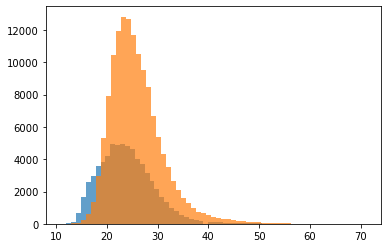

In [11]:
# Représentation de l'age des
grouped = df_events.groupby('Sex')
for group in grouped:
  plt.hist(group[1].Age, bins=60,  alpha=.7)

In [12]:
# Medaille par pays
df_events[['NOC', 'Medal']].groupby('NOC').count()

,Medal
NOC,
AFG,2
AHO,0
ALB,0
ALG,15
AND,0
...,...
YEM,0
YMD,0
YUG,321


In [13]:
# Avoir le stop avec le plus de medaille
df2 = df_events.groupby('Sport').count()
df2['Medal'].idxmax()

'Athletics'

In [14]:
# uniquelent les medaille d'or
df_events[df_events['Medal'] == "Gold"]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold
17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Horse Vault,Gold
17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Pommelled Horse,Gold
20,Kjetil Andr Aamodt,M,20.0,176.0,85.0,Norway,NOR,1992 Winter,1992,Winter,Albertville,Alpine Skiing,Alpine Skiing Men's Super G,Gold
20,Kjetil Andr Aamodt,M,30.0,176.0,85.0,Norway,NOR,2002 Winter,2002,Winter,Salt Lake City,Alpine Skiing,Alpine Skiing Men's Super G,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135503,Zurab Zviadauri,M,23.0,182.0,90.0,Georgia,GEO,2004 Summer,2004,Summer,Athina,Judo,Judo Men's Middleweight,Gold
135520,Julia Zwehl,F,28.0,167.0,60.0,Germany,GER,2004 Summer,2004,Summer,Athina,Hockey,Hockey Women's Hockey,Gold
135523,"Ronald Ferdinand ""Ron"" Zwerver",M,29.0,200.0,93.0,Netherlands,NED,1996 Summer,1996,Summer,Atlanta,Volleyball,Volleyball Men's Volleyball,Gold


In [15]:
# mediane de la hauteur et 
df_events[['Height', 'Weight']].median()

Height    175.0
Weight     70.0
dtype: float64